# Cross-species annotation
### PreProcessing (see on merge_data.ipynb)
0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
4) Normalization + log1p
5) Select HVGs
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill_value=0)

### Processing (this notebook)

8) Scale & PCA
9) Spearman correlation of PC to QC metrics & drop technical PC
9) Harmony integration
10) Neighbors / clustering on integrated representation
11) Compute overlap metrics (per-cluster entropy & species fractions)
12) Cross-validation evaluation (hide 20% human+mouse, majority-vote, cofusion matrix)

In [2]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Pre-processing
- Start with raw_merged data
- Filter
- Normalize
- Log transform
- Find HVG
- Combat (batch correction)

In [5]:
filename = '/home/raquelcr/scanpy/all_adata_outer2.h5ad'
adata = sc.read(filename)
print(f"Succesfully loaded {filename}. Shape: {adata.shape}")

Succesfully loaded /home/raquelcr/scanpy/all_adata_outer2.h5ad. Shape: (169567, 2669)


In [6]:
print(adata.shape)
print(adata.obs.columns)
print(adata.obs['dataset_name'].value_counts())

(169567, 2669)
Index(['label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type',
       'cell_supertype', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'tissue', 'sample_id',
       'replicate', 'sample', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id',
       'roi', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion',
       'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_

### QC metrics

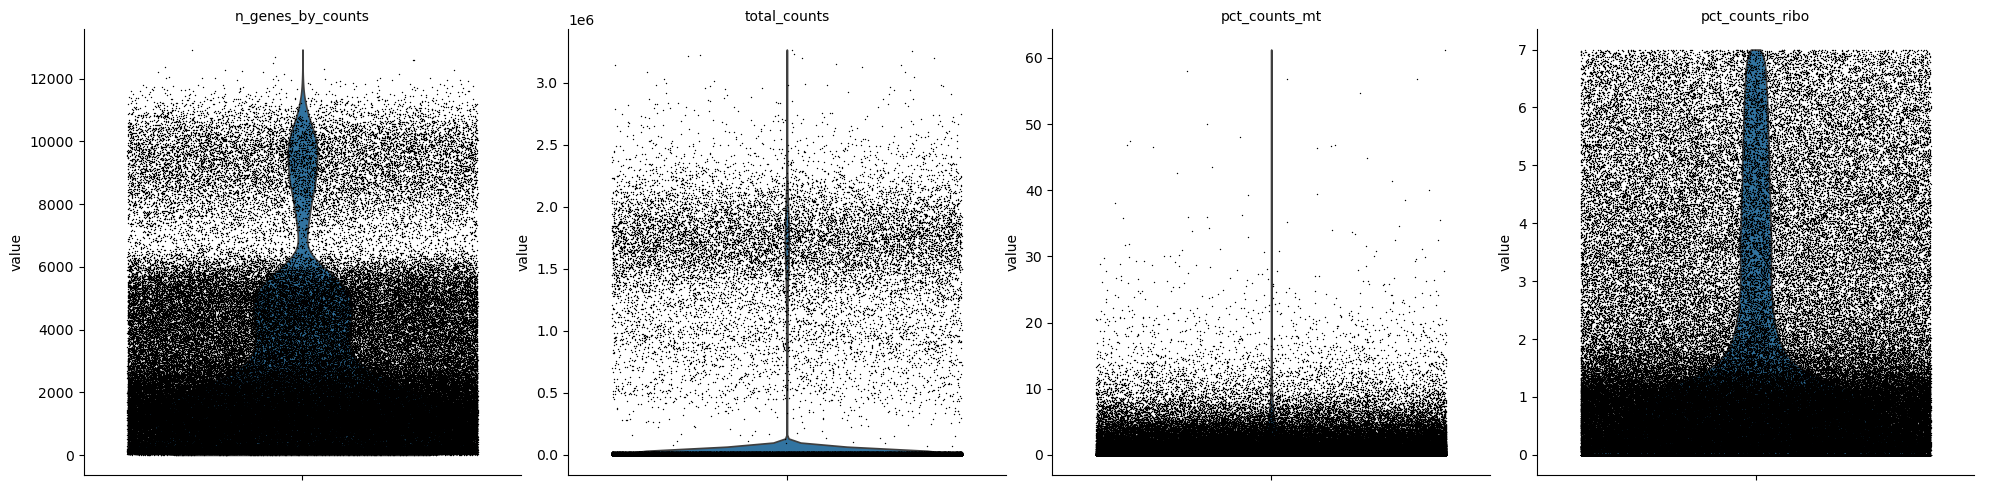

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
    jitter=0.4,
    multi_panel=True,
)

### Scale and PCA

In [8]:
sc.pp.scale(adata)
sc.pp.pca(adata, svd_solver='arpack')

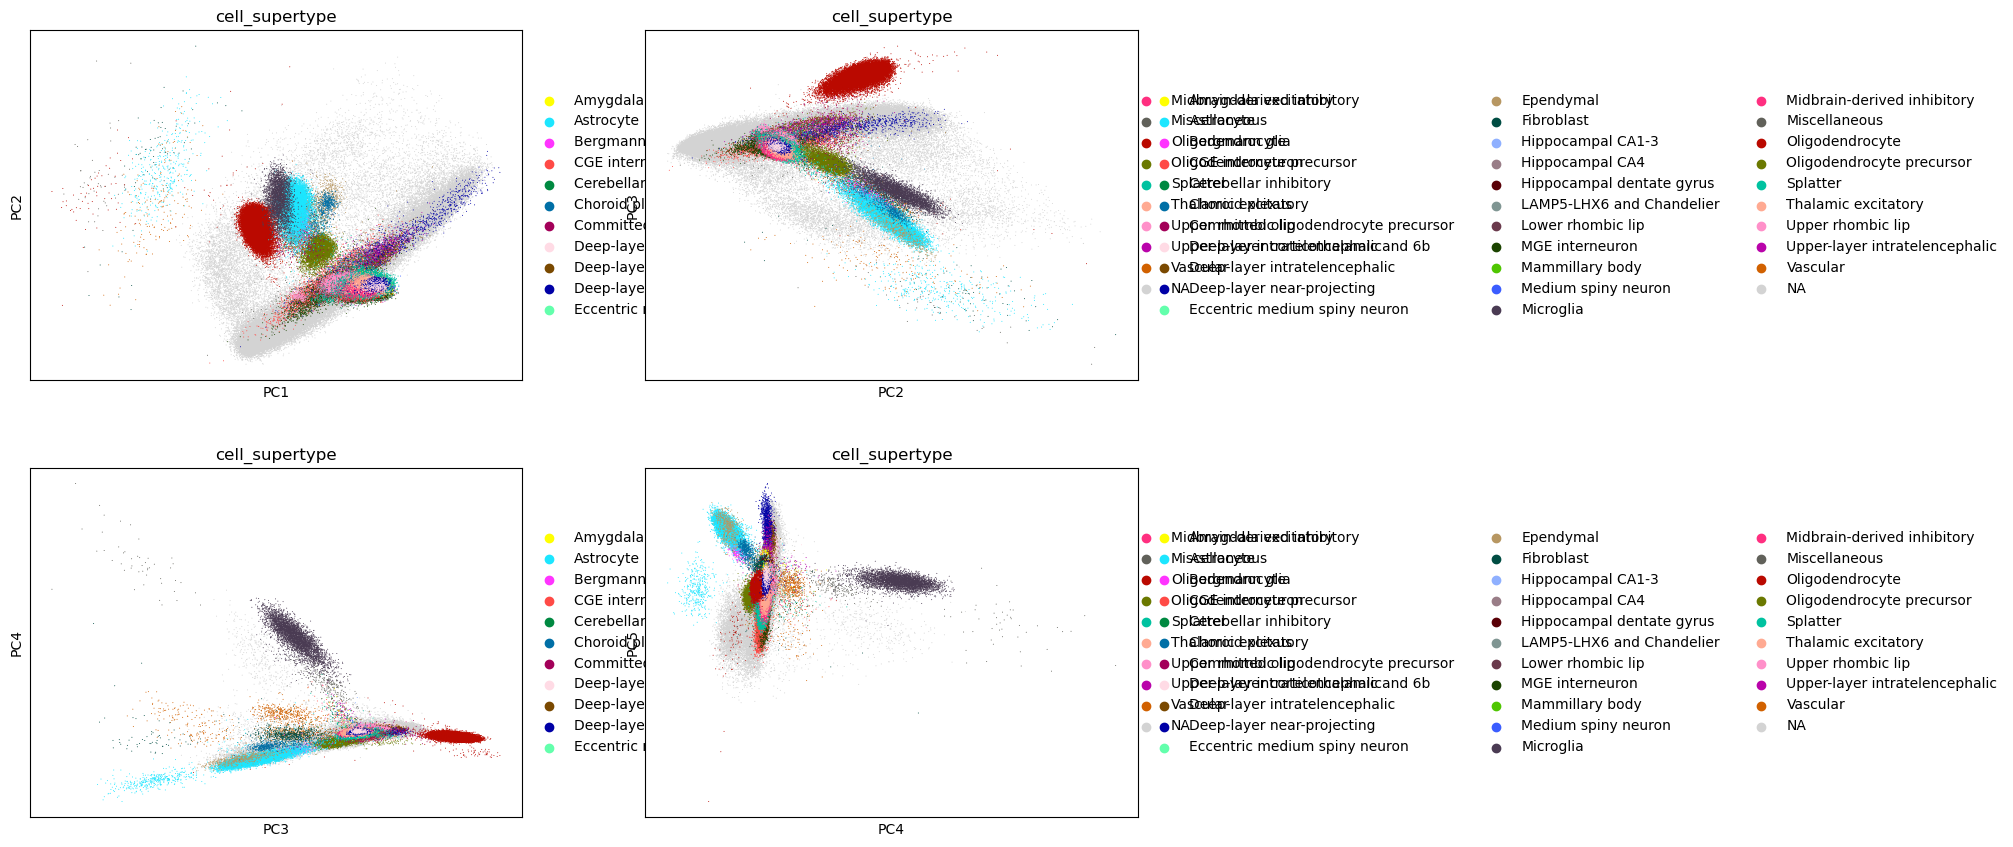

In [ ]:
sc.pl.pca(
    adata,
    color=["cell_supertype","cell_supertype", "cell_supertype", "cell_supertype"],
    dimensions=[(0,1),(1,2),(2,3),(3,4)],
    ncols=2,
    size=2,
    save='_by_supertype.png',
    legend_loc=False
)

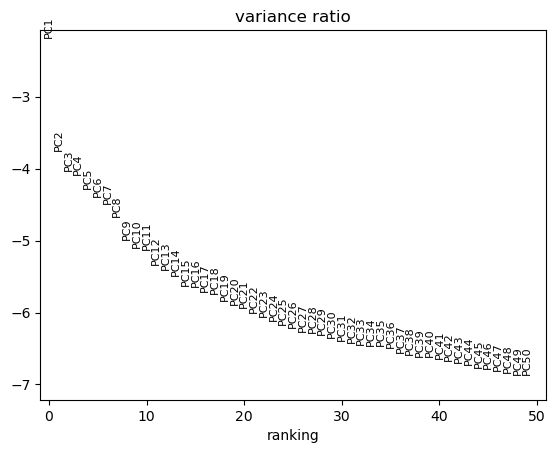

In [9]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [10]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
def check_pc_correlation(adata, n_pcs=None, pc_col_name="X_pca"):
    """Check correlation between PCs and QC metrics to identify potential confounders."""
    if n_pcs is None:
        n_pcs_check = adata.obsm[pc_col_name].shape[1]
    else: n_pcs_check = min(n_pcs, adata.obsm[pc_col_name].shape[1])
    pcs = pd.DataFrame(
        adata.obsm[pc_col_name][:, :n_pcs_check],
        index=adata.obs_names,
        columns=["PC"+str(i+1).zfill(2) for i in range(n_pcs_check)]
    )

    qc_cols = ["total_counts", "n_genes_by_counts", "pct_counts_mt", 'pct_counts_ribo']
    qc = adata.obs[qc_cols].astype(float)
    qc['species'] = adata.obs['species'].astype('category').cat.codes
    qc_cols.append('species')

    rows = []
    for pc in pcs.columns:
        for cov in qc_cols:
            # Spearman es más robusto; cambia a pearsonr si prefieres lineal
            r, p = spearmanr(pcs[pc].values, qc[cov].values, nan_policy="omit")
            rows.append({"PC": pc, "covariate": cov, "r": r, "p": p})

    corr = pd.DataFrame(rows)
    corr["q"] = multipletests(corr["p"], method="fdr_bh")[1]


    return corr

In [ ]:
def plot_pc_qc_correlation(corr, save_path=None):
    """Plot heatmap of PC vs QC metric correlations."""
    mat = corr.pivot(index="covariate", columns="PC", values="r")
    plt.figure(figsize=(10,3))
    im = plt.imshow(mat.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.colorbar(im, label="Spearman r")
    plt.title("Correlation PC vs QC")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    

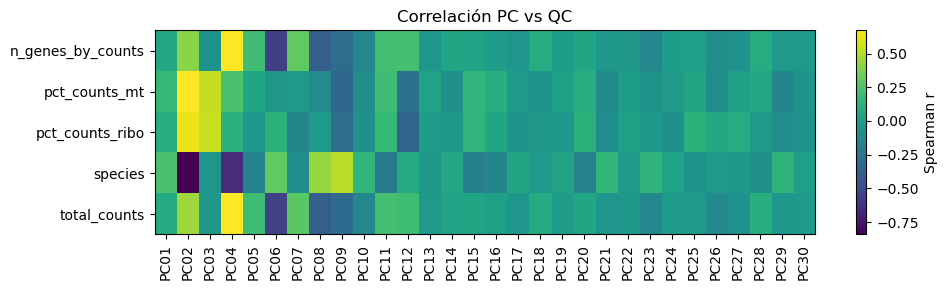

<Figure size 640x480 with 0 Axes>

In [12]:
origPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(origPCcorr, save_path='pc_qc_correlation_before_harmony.png')

In [31]:
# Mira a los sospechosos
origPCcorr.loc[(origPCcorr["q"] < 0.05) & (origPCcorr["PC"].isin([f"PC{i}" for i in range(1,11)]))].sort_values(["covariate","PC"])

PC          covariate         r              p              q
46  PC10  n_genes_by_counts -0.141180   0.000000e+00   0.000000e+00
47  PC10      pct_counts_mt -0.096465   0.000000e+00   0.000000e+00
48  PC10    pct_counts_ribo -0.078890  3.282142e-232  6.231916e-232
49  PC10            species  0.155141   0.000000e+00   0.000000e+00
45  PC10       total_counts -0.139119   0.000000e+00   0.000000e+00

In [16]:
# PC2 and PC4 looks problematic so I rather delete it
adata_copy = adata.copy() # save backup
adata.obsm["X_pca"] = np.delete(adata.obsm["X_pca"], [1,3], axis=1) 

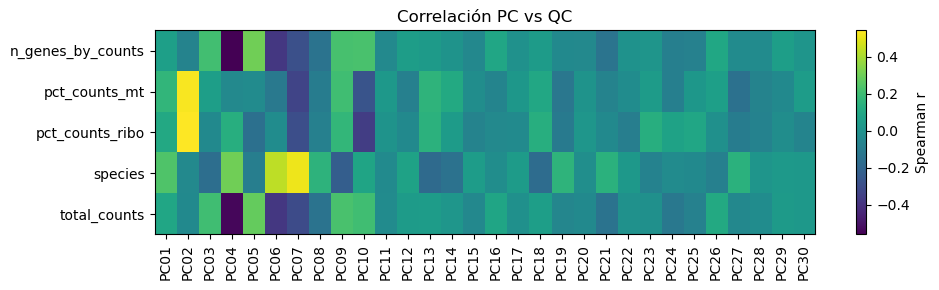

<Figure size 640x480 with 0 Axes>

In [ ]:
secondPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(secondPCcorr, save_path='pc_qc_correlation_pc2_dropped.png')
# just a little improvement

### Harmony Integration

In [19]:
pca_mat = adata.obsm['X_pca']
harmony_out = hm.run_harmony(pca_mat, adata.obs, 'dataset_name')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T  # check harmonypy return shape; adapt accordingly
# many wrappers exist; alternatively use sc.external.pp.harmony_integrate if available


2025-10-02 23:27:15,159 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-10-02 23:27:56,039 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-02 23:27:57,156 - harmonypy - INFO - Iteration 1 of 10
2025-10-02 23:29:17,490 - harmonypy - INFO - Iteration 2 of 10
2025-10-02 23:30:36,740 - harmonypy - INFO - Iteration 3 of 10
2025-10-02 23:32:09,573 - harmonypy - INFO - Iteration 4 of 10
2025-10-02 23:33:32,419 - harmonypy - INFO - Converged after 4 iterations


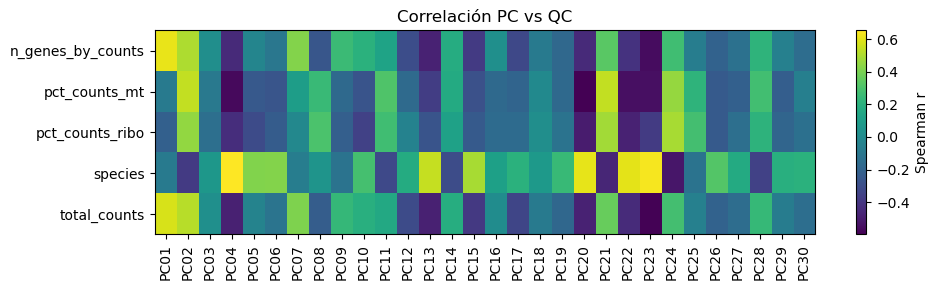

<Figure size 640x480 with 0 Axes>

In [20]:
harmonyPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca_harmony")
plot_pc_qc_correlation(harmonyPCcorr, save_path='pc_qc_correlation_after_harmony.png')

In [21]:
# sc.pp.combat(adata_hvg, key='dataset_name', inplace=True)
# combat is another type of batch correction, but harmonypy is generally better

### Neighbors
**Small n_neighbors** (e.g. 5–10): 

- Highlights fine-grained local relationships.

- Good for detecting rare cell populations. But can fragment larger, continuous populations into many tiny clusters.

**Large n_neighbors** (e.g. 30–50):

- Incorporates more global structure.

- Produces more coarse and global clusters.

- Good for datasets with strong batch effects (less sensitive to noise). But can miss rare cell types because they get merged into neighbors’ majority.


In [22]:
#Using rule of thumb  for n_neigbors used on neighors
import math
n_cells = adata.shape[0]
n_neighb = int(math.log10(n_cells) * 10)
print(f"Recommended n_neighbors ~ {n_neighb}")

Recommended n_neighbors ~ 52


In [23]:
rep = 'X_pca_harmony'  # use this integrated representation for clustering
sc.pp.neighbors(adata, use_rep=rep, n_neighbors=30,n_pcs=None) ## check if NONE is ok


/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Clustering

In [24]:
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_0.8')


### UMAP

In [25]:
sc.tl.umap(adata, min_dist=0.3) 

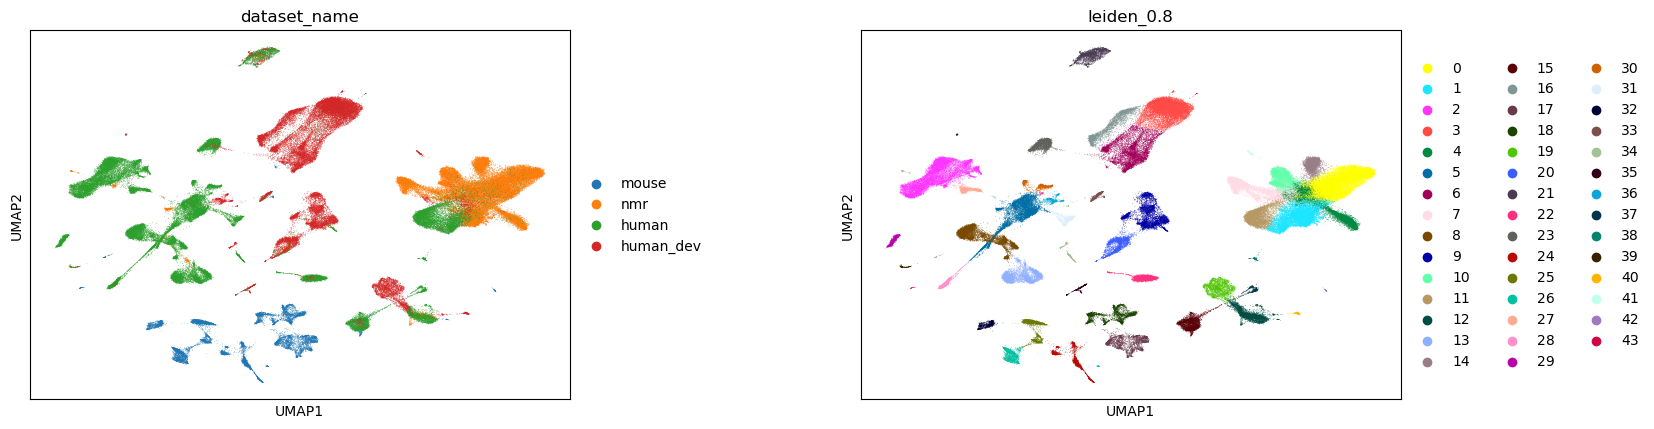

In [26]:
sc.pl.umap(adata, color=['dataset_name', 'leiden_0.8'], wspace=0.4, save="_clusters_harmony3.png")

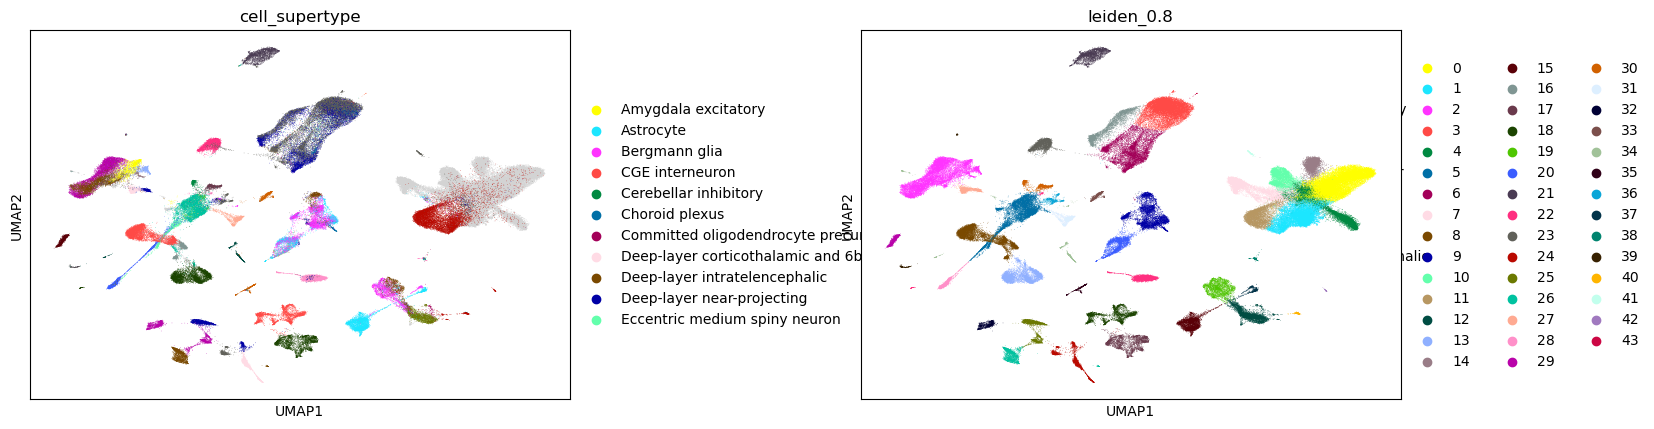

In [27]:
sc.pl.umap(adata, color=['cell_supertype', 'leiden_0.8'], wspace=0.4, save="_clusters_harmony_types3.png")

In [28]:
## CHECKPOINT
filename = '/home/raquelcr/scanpy/integrated_adata_clusters3.h5ad'
adata.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/integrated_adata_clusters3.h5ad


In [29]:
!cd /home/raquelcr/scanpy/

#### Don't re-run previous code ;)
(too slow)

In [30]:
try: adata = adata.copy()
except: adata = sc.read('/home/raquelcr/scanpy/integrated_adata_clusters3.h5ad')

## Metrics calculation

In [32]:
def shannon_entropy_from_counts(counts, base=2):
    """Shannon entropy from a list/array of counts."""
    counts = np.array(counts, dtype=float)
    if counts.sum() == 0:
        return 0.0
    p = counts / counts.sum()
    p = p[p > 0]
    return entropy(p, base=base)

def icc_1way_single_measure(groups, values):
    """
    Compute ICC(1) (one-way random effects) where groups is array-like group id per observation,
    values is numeric value per observation. This implementation follows Shrout & Fleiss formulation.
    Returns ICC(1) estimate. If degenerate, returns np.nan.
    """
    groups = np.asarray(groups)
    values = np.asarray(values, dtype=float)
    unique_g = np.unique(groups)
    k = len(unique_g)
    if k < 2:
        return np.nan
    # per-group stats
    n_i = np.array([np.sum(groups == g) for g in unique_g])
    mean_i = np.array([values[groups == g].mean() for g in unique_g])
    N = len(values)
    mean_all = values.mean()
    # Mean squares between and within
    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)
    ss_within = np.sum([(values[groups == g] - values[groups == g].mean()) ** 2 for g in unique_g])
    ms_within = ss_within / (N - k) if N > k else 0.0
    denom = ms_between + (n_i.mean() - 1) * ms_within
    if denom == 0:
        return np.nan
    icc = (ms_between - ms_within) / denom
    return float(icc)


In [33]:
def icc_1way_single_measure(groups, values):
    """
    One-way random effects ICC(1,1).
    groups: array of group labels
    values: array of numeric values
    """
    groups = np.array(groups)
    values = np.array(values, dtype=float)
    unique_g = np.unique(groups)

    N = len(values)
    k = len(unique_g)
    n_i = np.array([np.sum(groups == g) for g in unique_g])

    mean_all = np.mean(values)
    mean_i = np.array([np.mean(values[groups == g]) for g in unique_g])

    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)

    ss_within = sum(
        np.sum((values[groups == g] - values[groups == g].mean()) ** 2)
        for g in unique_g
    )
    ms_within = ss_within / (N - k) if N > k else 0.0

    denom = ms_between + (n_i.mean() - 1) * ms_within
    icc = (ms_between - ms_within) / denom if denom > 0 else 0.0
    return icc


In [34]:
def compute_cluster_metrics(adata,
                            species_col='species',
                            cluster_col='cluster',
                            ann_col='annotation',
                            species_list=('human', 'mouse', 'nmr')):
    """
    Returns a pandas DataFrame with metrics per cluster.
    """
    obs = adata.obs.copy()
    # ensure cluster col is string-like
    obs['_cluster_str'] = obs[cluster_col].astype(str)
    clusters = obs['_cluster_str'].unique()
    rows = []
    for cl in sorted(clusters, key=lambda x: (float(x) if x.replace('.','',1).isdigit() else x)):
        sub = obs[obs['_cluster_str'] == cl]
        n_cells = len(sub)
        # pct not annotated (cells where ann_col is NA / empty)
        not_ann = sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == '')
        pct_not_annotated = not_ann.sum() / max(1, n_cells)
        # species mix entropy
        species_counts = sub[species_col].value_counts()
        # make sure we compute entropy over species_list order if provided
        species_counts_list = [species_counts.get(s, 0) for s in species_list]
        ent_species = shannon_entropy_from_counts(species_counts_list, base=2)
        # ICC: here we compute ICC of "species label as numeric group" on a dummy numeric vector (1s),
        # but that's meaningless. A better practical ICC for per-cluster species homogeneity:
        # compute ICC of a binary indicator per species across annotated identities:
        # instead compute ICC of species fraction across per-cell one-hot for species groups.
        # Implementation: for this cluster, create groups = species, values = 1 for each cell,
        # then ICC is computed across species groups — this effectively measures between-group variance.
        # (This is a proxy; you can replace with another continuous metric if preferred.)
        groups = sub[species_col].values
        values = np.ones(len(sub))
        icc_sp = icc_1way_single_measure(groups, values)
        # For human and mouse majority annotation within cluster:
        info = {'cluster': cl, 'n_cells': n_cells,
                'pct_not_annotated': pct_not_annotated,
                'shannon_entropy_species': ent_species,
                'icc_species_fraction': icc_sp}
        for sp in ['human', 'mouse']:
            sub_sp = sub[sub[species_col] == sp]
            if len(sub_sp) == 0:
                info[f'{sp}_majority_annotation'] = np.nan
                info[f'{sp}_majority_frac'] = np.nan
            else:
                # among these, consider only annotated cells
                ann_counts = sub_sp[~(sub_sp[ann_col].isna() | (sub_sp[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
                if ann_counts.sum() == 0:
                    info[f'{sp}_majority_annotation'] = np.nan
                    info[f'{sp}_majority_frac'] = 0.0
                else:
                    maj_ann = ann_counts.idxmax()
                    maj_frac = ann_counts.loc[maj_ann] / ann_counts.sum()
                    info[f'{sp}_majority_annotation'] = maj_ann
                    info[f'{sp}_majority_frac'] = float(maj_frac)
        # global majority among annotated cells in cluster
        ann_counts_global = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts_global.sum() == 0:
            info['global_majority_annotation'] = np.nan
            info['global_majority_frac'] = 0.0
        else:
            gmaj = ann_counts_global.idxmax()
            info['global_majority_annotation'] = gmaj
            info['global_majority_frac'] = float(ann_counts_global.loc[gmaj] / ann_counts_global.sum())
        rows.append(info)
    cluster_metrics = pd.DataFrame(rows).set_index('cluster')
    return cluster_metrics


In [35]:
def assign_cluster_majority(adata, cluster_metrics, ann_col='annotation', cluster_col='cluster'):
    """Add predicted annotation to adata.obs as 'predicted_annotation' based on cluster global majority."""
    obs = adata.obs
    # map cluster -> global_majority_annotation
    mapping = cluster_metrics['global_majority_annotation'].to_dict()
    obs['predicted_annotation'] = obs[cluster_col].astype(str).map(mapping).astype(object)
    # leave as NaN where mapping missing
    return None  # adata modified in place

In [36]:
# Pipeline for cross-species cluster-based annotation + metrics

def cross_validate_cluster_majority(adata,
                                    ann_col='annotation',
                                    species_col='species',
                                    cluster_col='cluster',
                                    species_to_mask=('human', 'mouse'),
                                    test_fraction=0.2,
                                    random_state=0):
    """
    For each species in species_to_mask:
      - stratify by annotation (if enough cells) and select test_fraction to hide
    Then: compute cluster majority using remaining labels and predict on held-out labels.
    Returns accuracy, confusion matrix and the indices of test cells.
    """
    obs = adata.obs.copy()
    # get indices for candidates (human+mouse annotated)
    candidates = obs[obs[species_col].isin(species_to_mask)].copy()
    # ensure annotated
    candidates = candidates[~(candidates[ann_col].isna() | (candidates[ann_col].astype(str).str.strip() == ''))]
    if candidates.empty:
        raise ValueError("No annotated human/mouse cells found for cross-validation.")
    test_idx = []
    train_mask = pd.Series(True, index=obs.index)
    # stratify within each species separately
    for sp in species_to_mask:
        sp_idx = candidates[candidates[species_col] == sp].index
        if len(sp_idx) == 0:
            continue
        y = candidates.loc[sp_idx, ann_col].values
        # if number of unique classes small or counts small, train_test_split stratify might fail.
        try:
            train_i, test_i = train_test_split(sp_idx, test_size=test_fraction, stratify=y, random_state=random_state)
        except Exception:
            # fallback: random sample
            test_i = np.random.RandomState(random_state).choice(sp_idx, size=max(1, int(len(sp_idx)*test_fraction)), replace=False)
            train_i = [i for i in sp_idx if i not in test_i]
        test_idx.extend(list(test_i))
        # mark those as hidden for training
        train_mask.loc[test_i] = False
    # create a copy of annotations for training where we mask test_idx
    obs_train = obs.copy()
    obs_train.loc[test_idx, ann_col] = np.nan
    # compute cluster majority from obs_train
    # build cluster -> majority annotation across all annotated cells in cluster (human+mouse+other if present)
    cluster_majority = {}
    for cl, sub in obs_train.groupby(cluster_col):
        ann_counts = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts.sum() == 0:
            cluster_majority[cl] = np.nan
        else:
            cluster_majority[cl] = ann_counts.idxmax()
    # predictions for test cells
    y_true = obs.loc[test_idx, ann_col].values
    y_pred = [cluster_majority.get(cl, np.nan) for cl in obs.loc[test_idx, cluster_col].astype(str).values]
    # compute accuracy (ignore nan predictions if they occur)
    mask_valid = pd.Series(y_pred).notna().values
    if mask_valid.sum() == 0:
        acc = np.nan
    else:
        acc = accuracy_score(np.array(y_true)[mask_valid], np.array(y_pred)[mask_valid])
    # confusion matrix across classes that appear in true set (will include only predicted ones for which mapping exists)
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, pd.Series(y_pred), labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return {'accuracy': float(acc) if not np.isnan(acc) else np.nan,
            'confusion_matrix': cm_df,
            'n_test': len(test_idx),
            'test_idx': test_idx,
            'cluster_majority_from_train': cluster_majority}



In [38]:
adata = adata
cluster_metrics = compute_cluster_metrics(adata, species_col='species', cluster_col='leiden_0.8', ann_col='cell_supertype')
print(cluster_metrics.head())
assign_cluster_majority(adata, cluster_metrics, ann_col='cell_supertype', cluster_col='leiden_0.8')
cv_results = cross_validate_cluster_majority(adata, ann_col='cell_supertype', cluster_col='leiden_0.8', species_col='species')
print("CV accuracy:", cv_results['accuracy'])
print("Confusion matrix:\n", cv_results['confusion_matrix'])
cluster_metrics.to_csv('/home/raquelcr/scanpy/harmony_cluster_metrics.csv')

         n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0          20189           0.975581                 0.165581   
1          13557           0.703105                 0.877462   
2          12003           0.013580                 0.103686   
3          11732           0.000000                 0.004419   
4           8369           0.967619                 0.206197   

         icc_species_fraction       human_majority_annotation  \
cluster                                                         
0                         0.0                 Oligodendrocyte   
1                         0.0                 Oligodendrocyte   
2                         0.0  Upper-layer intratelencephalic   
3                         0.0                   Miscellaneous   
4                         0.0                 Oligodendrocyte   

         human_majority_frac mouse_majority_annotation  mouse_majority_frac  \
cluster         

In [39]:
adata.obs

label  sizeFactor subclass   n_counts species  \
F1S4_160108_001_A01          Vip    1.085313      Vip  1730700.0   mouse   
F1S4_160108_001_B01        Lamp5    1.197503    Lamp5  1909605.0   mouse   
F1S4_160108_001_C01        Lamp5    1.244751    Lamp5  1984948.0   mouse   
F1S4_160108_001_D01          Vip    1.437020      Vip  2291552.0   mouse   
F1S4_160108_001_E01        Lamp5    1.102096    Lamp5  1757463.0   mouse   
...                          ...         ...      ...        ...     ...   
10X178_3:GGGTTTAGTCTCAGGC    NaN         NaN      NaN        NaN   human   
10X147_1:TGGTTAGCATGTTGAC    NaN         NaN      NaN        NaN   human   
10X178_2:TTTATGCTCATGAGTC    NaN         NaN      NaN        NaN   human   
10X178_3:CCACGTTGTACAAGCG    NaN         NaN      NaN        NaN   human   
10X178_4:TCACATTCAGACCATT    NaN         NaN      NaN        NaN   human   

                          cell_type   cell_supertype  n_genes_by_counts  \
F1S4_160108_001_A01         CGE_276  CGE interneuron               9029   
F1S4_160108_001_B01         CGE_277  CGE interneuron              10207   
F1S4_160108_001_C01         CGE_277  CGE interneuron              10578   
F1S4_160108_001_D01         CGE_276  CGE interneuron               8482   
F1S4_160108_001_E01         CGE_277  CGE interneuron               8697   
...                             ...              ...                ...   
10X178_3:GGGTTTAGTCTCAGGC    Bgl_51    Bergmann glia               2437   
10X147_1:TGGTTAGCATGTTGAC    Bgl_51    Bergmann glia                824   
10X178_2:TTTATGCTCATGAGTC    Bgl_51    Bergmann glia               2219   
10X178_3:CCACGTTGTACAAGCG    Bgl_51    Bergmann glia               1803   
10X178_4:TCACATTCAGACCATT    Bgl_51    Bergmann glia               1395   

                           log1p_n_genes_by_counts  total_counts  ...  \
F1S4_160108_001_A01                       9.108308     1730700.0  ...   
F1S4_160108_001_B01                       9.230927     1909605.0  ...   
F1S4_160108_001_C01                       9.266626     1984948.0  ...   
F1S4_160108_001_D01                       9.045819     2291552.0  ...   
F1S4_160108_001_E01                       9.070848     1757463.0  ...   
...                                            ...           ...  ...   
10X178_3:GGGTTTAGTCTCAGGC                 7.798933        6644.0  ...   
10X147_1:TGGTTAGCATGTTGAC                 6.715383        1348.0  ...   
10X178_2:TTTATGCTCATGAGTC                 7.705262        5538.0  ...   
10X178_3:CCACGTTGTACAAGCG                 7.497762        3808.0  ...   
10X178_4:TCACATTCAGACCATT                 7.241366        2540.0  ...   

                           tissue_type  tissue_ontology_term_id  \
F1S4_160108_001_A01                NaN                      NaN   
F1S4_160108_001_B01                NaN                      NaN   
F1S4_160108_001_C01                NaN                      NaN   
F1S4_160108_001_D01                NaN                      NaN   
F1S4_160108_001_E01                NaN                      NaN   
...                                ...                      ...   
10X178_3:GGGTTTAGTCTCAGGC       tissue           UBERON:0002028   
10X147_1:TGGTTAGCATGTTGAC       tissue           UBERON:0001896   
10X178_2:TTTATGCTCATGAGTC       tissue           UBERON:0002028   
10X178_3:CCACGTTGTACAAGCG       tissue           UBERON:0002028   
10X178_4:TCACATTCAGACCATT       tissue           UBERON:0002028   

                           cell_type_ontology_term_id  fraction_mitochondrial  \
F1S4_160108_001_A01                               NaN                     NaN   
F1S4_160108_001_B01                               NaN                     NaN   
F1S4_160108_001_C01                               NaN                     NaN   
F1S4_160108_001_D01                               NaN                     NaN   
F1S4_160108_001_E01                               NaN                     NaN   
...                                          

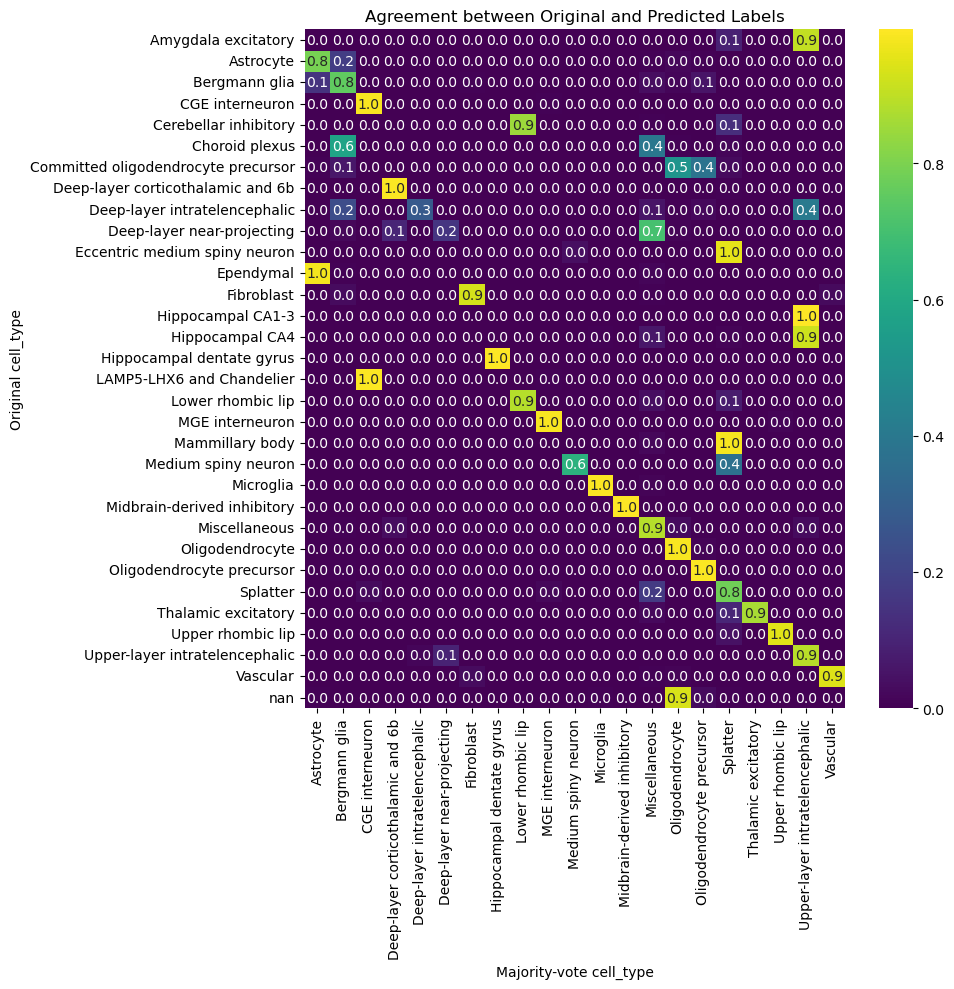

In [40]:
# Build confusion matrix
true_labels = adata.obs["cell_supertype"].astype(str)
pred_labels = adata.obs["predicted_annotation"].astype(str)

cm = pd.crosstab(true_labels, pred_labels, rownames=["Original"], colnames=["Majority-vote"])

# Normalize rows (fractions per original label, easier to read)
cm_norm = cm.div(cm.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis")
plt.title("Agreement between Original and Predicted Labels")
plt.ylabel("Original cell_type")
plt.xlabel("Majority-vote cell_type")
plt.tight_layout()
plt.show()

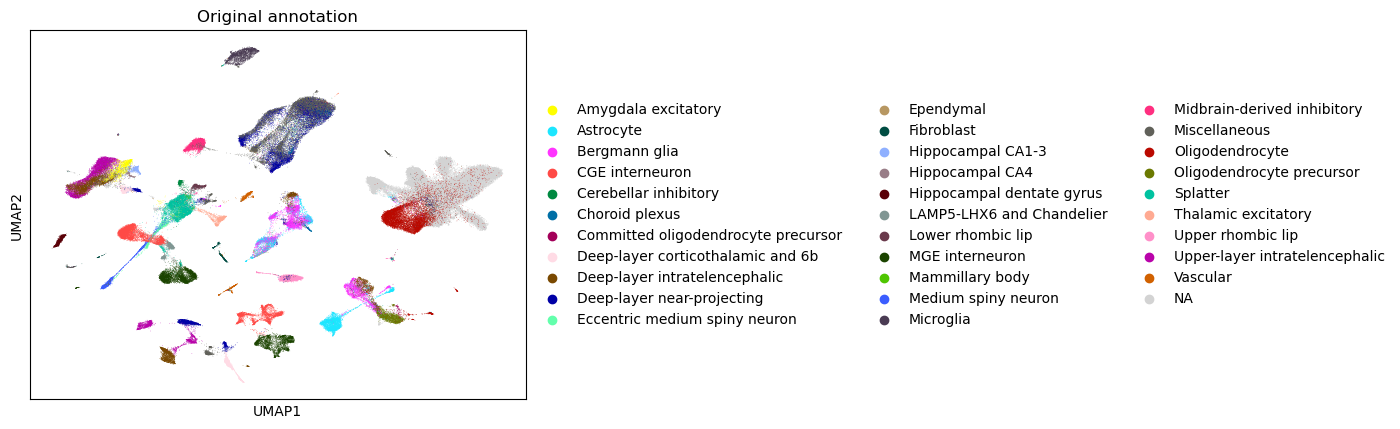

In [41]:
# Plot side by side
sc.pl.umap(
    adata,
    color="cell_supertype",
    title="Original annotation"
)

In [69]:
dissection = [str(a).split(' - ')[0] for a in adata.obs['dissection'].unique().to_list()]

In [74]:
adata.obs['dissect'] = [str(a).split(' - ')[0] for a in adata.obs['dissection']]

In [72]:
print(set(dissection))
len(set(dissection))

{'Medulla', 'Frontotemporal cortex', 'Hypothalamus', 'Striatum', 'Mesencephalon', 'Perirhinal cortex (area 35) (A35)', 'Midbrain', 'Amygdaloid complex (AMY)', 'Midbrain (M)', 'Cerebellum', 'Subcortex', 'Forebrain cortex', 'Hindbrain', 'Cortical hem', 'Claustrum', 'Midbrain (RN)', 'Brain', 'Telencephalon', 'Enthorinal cortex', 'Spinal cord', 'Dorsal midbrain', 'Ventral midbrain', 'Upper cortex', 'Head of hippocampus (HiH)', 'Cerebral cortex (Cx)', 'Head', 'Body of hippocampus (HiB)', 'Paleocortex (PalCx)', 'Subcortical forebrain', 'Cortex', 'Extended amygdala (EXA)', 'Thalamus (THM)', 'Basal forebrain (BF)', 'Pons/Medulla', 'Caudate-Putamen', 'nan', 'Pons (Pn)', 'Myelencephalon (medulla oblongata) (Mo)', 'Tail of Hippocampus (HiT)', 'Thalamus', 'Diencephalon', 'Tel/diencephalon', 'Epithalamus', 'Lower cortex', 'Pons', 'Forebrain', 'Hypothalamus (HTH)', 'Cerebellum (CB)', 'Hippocampus', 'Occipital cortex', 'Basal nuclei (BN)', 'Pons/Cereb'}


52

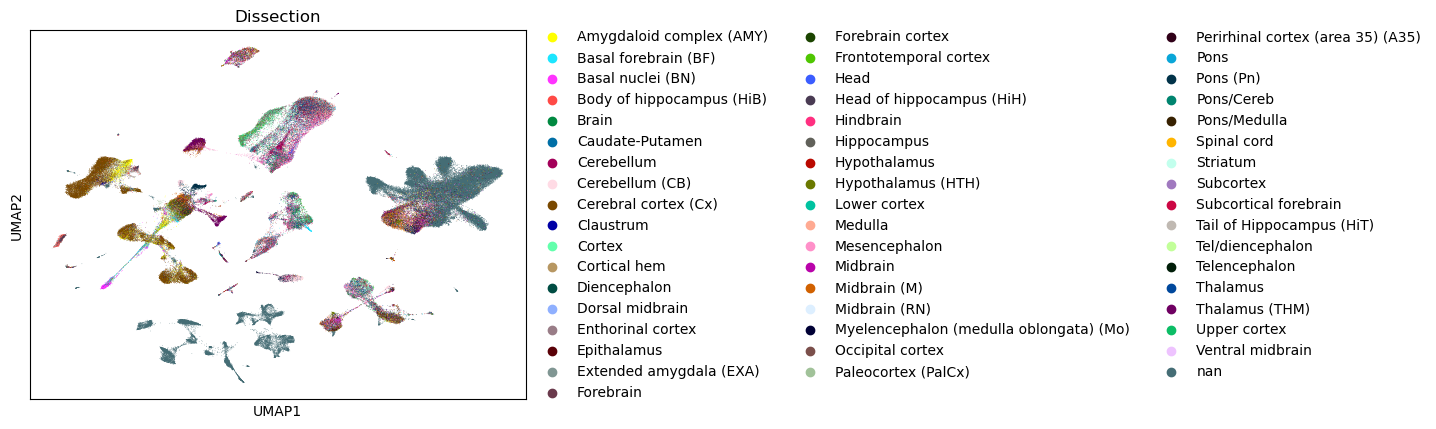

In [75]:
# Plot side by side
sc.pl.umap(
    adata,
    color="dissect",
    title="Dissection"
)

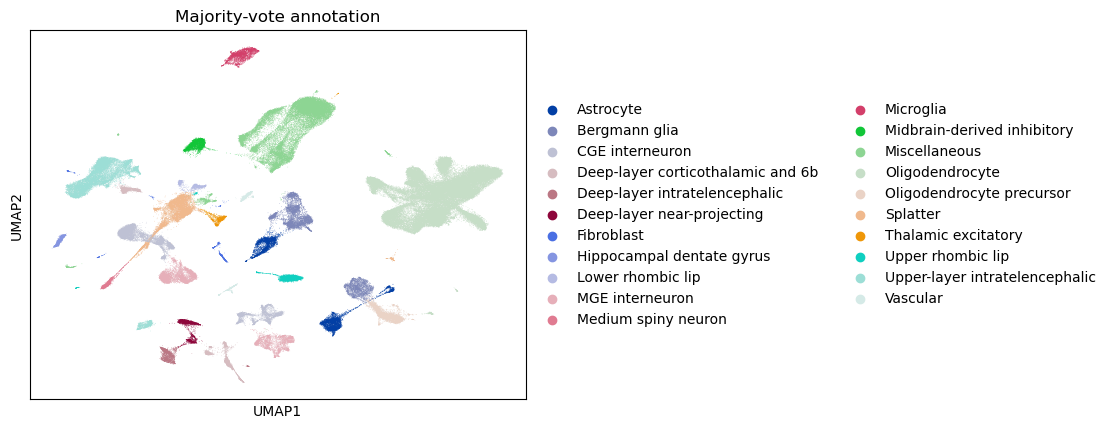

In [42]:
# Plot side by side
sc.pl.umap(
    adata,
    color="predicted_annotation",
    title="Majority-vote annotation"
)

In [43]:
nmr_data = adata[adata.obs['species'] == 'nmr'].copy()

In [44]:
nmr_data

AnnData object with n_obs × n_vars = 57171 × 2669
    obs: 'label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type', 'cell_supertype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'tissue', 'sample_id', 'replicate', 'sample', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', '

<Axes: title={'center': 'Only NMR predicted annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

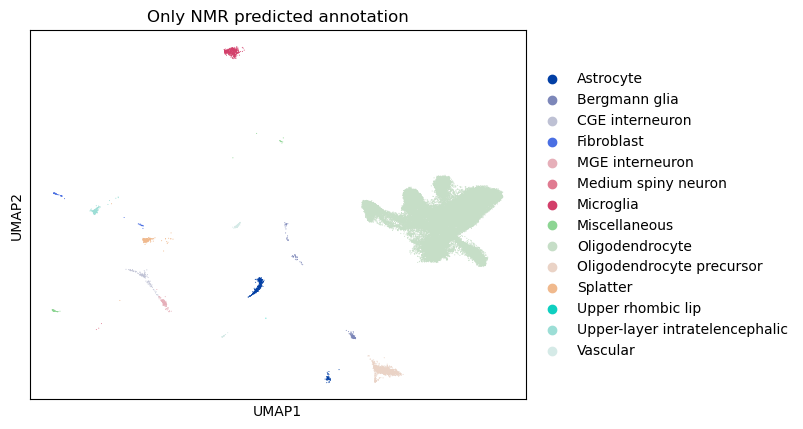

In [45]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    show=False,
    title="Only NMR predicted annotation"
)

<Axes: title={'center': 'Only NMR by tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

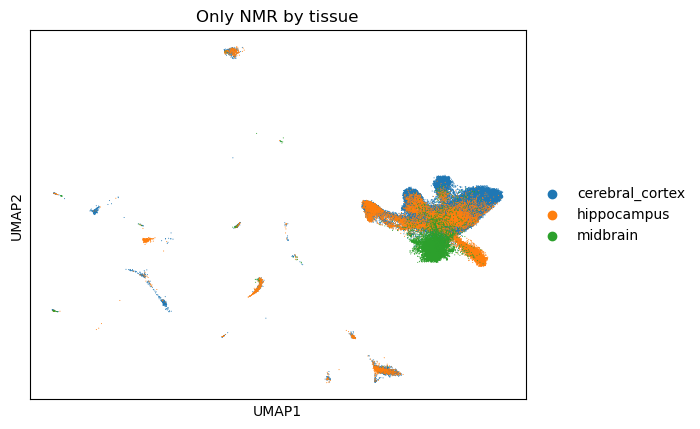

In [46]:
sc.pl.umap(
    adata[adata.obs['species'] == 'nmr'],
    color="tissue",
    show=False,
    title="Only NMR by tissue"
)


In [47]:
sc.pp.pca(nmr_data, svd_solver='arpack')
sc.pp.neighbors(nmr_data, n_neighbors=15, n_pcs=40)
sc.tl.umap(nmr_data)


<Axes: title={'center': 'Only NMR predicted annotation (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

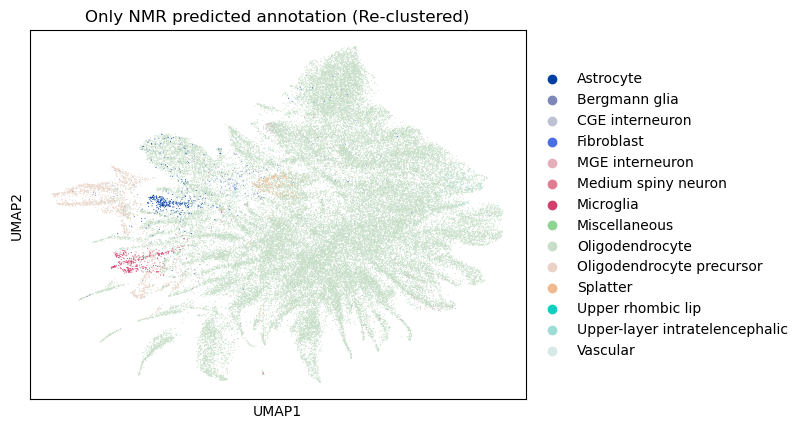

In [48]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    show=False,
    title="Only NMR predicted annotation (Re-clustered)")

In [49]:
nmr_data.obs['predicted_annotation'].value_counts()

predicted_annotation
Oligodendrocyte                   53477
Oligodendrocyte precursor          1695
Astrocyte                           381
Microglia                           372
Splatter                            324
Upper-layer intratelencephalic      163
Vascular                            158
Bergmann glia                       147
Miscellaneous                       129
MGE interneuron                     129
CGE interneuron                     111
Fibroblast                           81
Medium spiny neuron                   3
Upper rhombic lip                     1
Name: count, dtype: int64

<Axes: title={'center': 'Only NMR by cluster (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

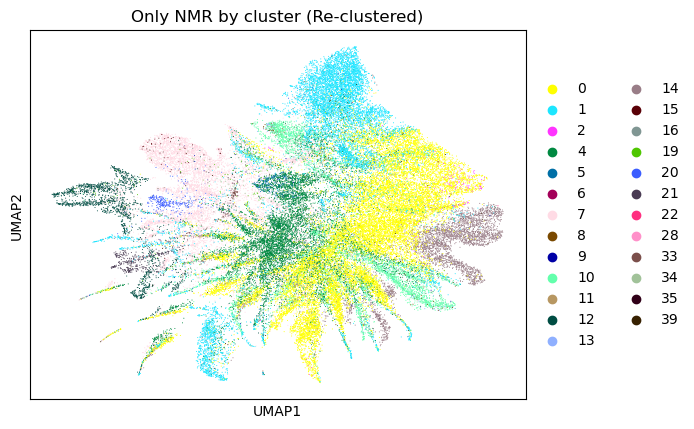

In [50]:
sc.pl.umap(
    nmr_data,
    color="leiden_0.8",
    show=False,
    title="Only NMR by cluster (Re-clustered)"
)

<Axes: title={'center': 'Only NMR by cluster (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

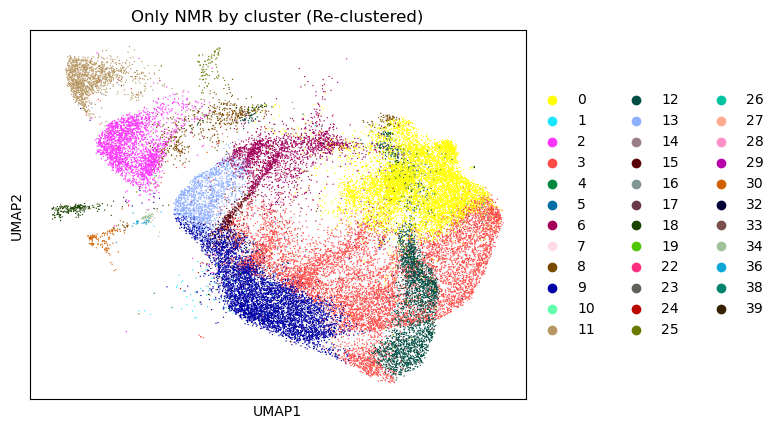

In [ ]:
sc.pl.umap(
    corteza,
    color="leiden_0.8",
    show=False,
    title="Only NMR by cluster (Re-clustered)"
)

<Axes: title={'center': 'Only NMR by tissue (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

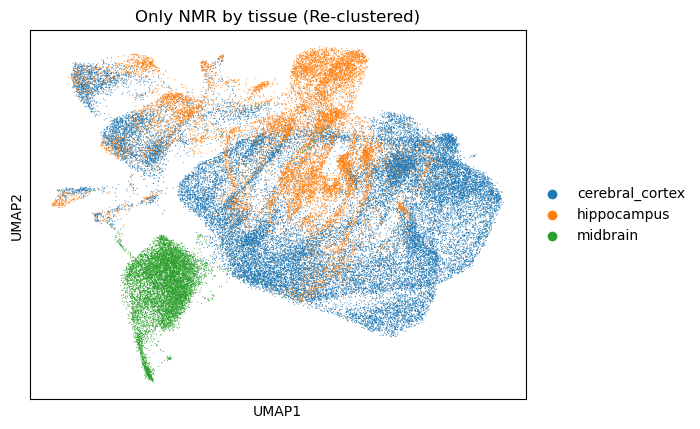

In [ ]:
sc.pl.umap(
    nmr_data,
    color="tissue",
    show=False,
    title="Only NMR by tissue (Re-clustered)"
)

In [ ]:
nmr_data.obs.columns

Index(['label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type',
       'cell_supertype', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'tissue', 'sample_id',
       'replicate', 'sample', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id',
       'roi', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion',
       'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id',
       'fr

GGGTGAATCTAGCCAA-1-NMR2     True
AAAGGGCAGTTTGGCT-1-NMR2     True
CAGAGCCGTAGATGTA-1-NMR2     True
GCACATACACCTCTGT-1-NMR2     True
ATCGGCGAGGGACACT-1-NMR2     True
                           ...  
TACCGGGTCGTTCTCG-1-NMR6    False
AGTACTGTCGCTTAAG-1-NMR6    False
GGTGGCTCACAGTCGC-1-NMR6    False
ATCTCTACAGTCGTTA-1-NMR6    False
ACTATCTAGAGGCGTT-1-NMR6    False
Name: tissue, Length: 57171, dtype: bool

In [ ]:
corteza = nmr_data[nmr_data.obs['tissue'] == 'cerebral_cortex'].copy(

<Axes: title={'center': 'Only NMR (corteza)'}, xlabel='UMAP1', ylabel='UMAP2'>

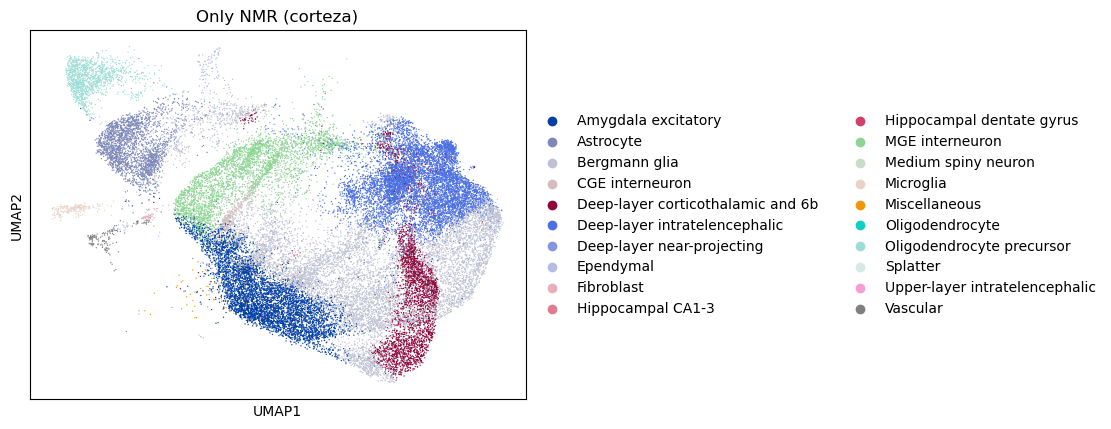

In [ ]:
sc.pl.umap(
    corteza,
    color="predicted_annotation",
    show=False,
    title="Only NMR (corteza)"
)

In [ ]:
corteza.obs['predicted_annotation'].value_counts()

predicted_annotation
Bergmann glia                        8774
Deep-layer intratelencephalic        7671
Amygdala excitatory                  5366
MGE interneuron                      3716
Deep-layer corticothalamic and 6b    3124
Astrocyte                            2376
Oligodendrocyte precursor            1294
CGE interneuron                       402
Microglia                             247
Vascular                              159
Ependymal                             112
Miscellaneous                         102
Splatter                               87
Fibroblast                             51
Deep-layer near-projecting             15
Hippocampal dentate gyrus              12
Oligodendrocyte                        12
Upper-layer intratelencephalic          5
Medium spiny neuron                     2
Hippocampal CA1-3                       1
Name: count, dtype: int64

In [ ]:
# Save object
filename= '/home/raquelcr/scanpy/final_nmr_crossAnn.h5ad'
sc.write(nmr_data,filename)
print(f'Succesfully saved on {filename}')

In [ ]:
adata.obs[adata.obs['species'] == 'human']["dissection"].counts()

AttributeError: 'Series' object has no attribute 'counts'

In [ ]:
adata.obs[adata.obs['species'] == 'human'].groupby('dissection').count()['label']

dissection
Amygdaloid complex (AMY) - Basolateral nuclear group (BLN) - lateral nucleus - La                                 0
Amygdaloid complex (AMY) - Central nuclear group - CEN                                                            0
Amygdaloid complex (AMY) - Corticomedial nuclear group (CMN) - anterior cortical nucleus - CoA                    0
Amygdaloid complex (AMY) - basolateral nuclear group (BLN) - basolateral nucleus (basal nucleus) - BL             0
Amygdaloid complex (AMY) - basolateral nuclear group (BLN) - basomedial nucleus (accessory basal nucleus) - BM    0
                                                                                                                 ..
Thalamus (THM) - medial nuclear complex of thalamus (MNC) - mediodorsal nucleus of thalamus - MD                  0
Thalamus (THM) - posterior nuclear complex of thalamus (PoN) - lateral geniculate nucleus (LG)                    0
Thalamus (THM) - posterior nuclear complex of thalamus (PoN) 

In [ ]:
corteza.var_names[:100]

Index(['1700020A23Rik', '1700034E13Rik', '2310022A10Rik', '2610028H24Rik',
       '2610318N02Rik', '2700097O09Rik', '6030468B19Rik', 'A1CF', 'A2m',
       'AASS', 'AATF', 'ABAT', 'ABCA1', 'ABCA13', 'ABCA3', 'ABCA8', 'ABCA9',
       'ABCB7', 'ABCC2', 'ABCC4', 'ABCC6', 'ABCC9', 'ABCD1', 'ABCD2', 'ABCD3',
       'ABHD15', 'ABHD4', 'ABI3', 'ABI3BP', 'ABLIM2', 'ABLIM3', 'ABR', 'ABRA',
       'ABTB2', 'ABTB3', 'ACAA2', 'ACACB', 'ACAD10', 'ACAD11', 'ACBD4', 'ACE2',
       'ACKR4', 'ACMSD', 'ACO1', 'ACOX2', 'ACP5', 'ACRBP', 'ACSBG1', 'ACSF2',
       'ACSL6', 'ACSM2A', 'ACSM3', 'ACSS3', 'ACTA2', 'ACTC1', 'ACTG1', 'ACTG2',
       'ACTL7A', 'ACTN3', 'ACTR3B', 'ACTR8', 'ACVR1C', 'ACVR2B', 'ACY1',
       'ACYP1', 'ADA', 'ADAL', 'ADAM12', 'ADAM15', 'ADAM19', 'ADAM28', 'ADAM9',
       'ADAMDEC1', 'ADAMTS1', 'ADAMTS10', 'ADAMTS12', 'ADAMTS14', 'ADAMTS15',
       'ADAMTS16', 'ADAMTS17', 'ADAMTS18', 'ADAMTS19', 'ADAMTS2', 'ADAMTS20',
       'ADAMTS5', 'ADAMTS6', 'ADAMTS9', 'ADAP2', 'ADARB1', 'ADARB2', '